In [15]:
import matplotlib.pyplot as plt
import  numpy as np
import  pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import seaborn as sns

from imblearn.over_sampling import RandomOverSampler
import random
import tensorflow as tf
import warnings


from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import LearningCurveDisplay, learning_curve, KFold, cross_val_score
from numpy.typing import ArrayLike






warnings.simplefilter(action='ignore', category=FutureWarning)
sns.set_theme(style="ticks")
sns.set_palette("viridis")

### Helper functions

In [16]:
df_data= pd.read_csv(os.path.join('..','data', 'cs-training.csv'))
def cleanData(df):
    '''
    Args:
            df (Pandas DataFrame): A pandas DataFrame to be cleaned and split

    Returns:
            X_train (Pandas DataFrame): Pandas DataFrame with a portion of 80% of the dataframe through *train_test_split* sklearn method 
            X_test (Pandas DataFrame): Pandas DataFrame with a portion of 20% of the dataframe through *train_test_split* sklearn method 
            y_train (Pandas Series): Pandas Series with a portion of 80% of the dataframe through *train_test_split* sklearn method
            y_test (Pandas Series): Pandas Series with a portion of 20% of the dataframe through *train_test_split* sklearn method


    '''
    df.rename(columns={"Unnamed: 0": "ID",
                            "RevolvingUtilizationOfUnsecuredLines": "balance_divided_creditlimit", 
                            "NumberOfTime60-89DaysPastDueNotWorse": "number_times_latepay60-89"}, inplace=True)

    df.dropna(inplace=True)
    df= df[df['age'] >=18 ]
    df= df[df['NumberOfTime30-59DaysPastDueNotWorse']<96  ]
    df= df[df['balance_divided_creditlimit']<=1]

    
    garbage_columns= ["ID","SeriousDlqin2yrs", "NumberOfTime30-59DaysPastDueNotWorse"]
    X_train, X_test, y_train, y_test = train_test_split( df.drop(garbage_columns, axis=1), df["SeriousDlqin2yrs"], test_size=0.2)
    return X_train, X_test, y_train, y_test


def overSampling(X: pd.DataFrame | ArrayLike, y: pd.Series | ArrayLike):
    '''
    Args:
        X (Pandas DataFrame | ArrayLike): Pandas DataFrame to use a Over-sampling technique to avoid unbalanced dataset
        Y (Pandas Series | ArrayLike): Pandas Series to use a Over-sampling technique to avoid unbalanced dataset
    Returns:
        X (Pandas DataFrame | ArrayLike): Pandas DataFrame with over-sampling aplied
        Y (Pandas Series | ArrayLike): Pandas Series with over-sampling aplied

    '''
    ros = RandomOverSampler(random_state=0)
    X_resampled, y_resampled = ros.fit_resample(X, y)
    
    return X_resampled, y_resampled



def plot_roc(y_true: pd.Series | ArrayLike, y_score: pd.Series | ArrayLike):
    '''
    Args:
        y_true (Pandas Series | Numpy Array | ArrayLike): Actual Y from your dataset
        y_score (Pandas Series | Numpy Array | ArrayLike): Probabily estimator of your dataset
    Returns:
        A Roc/Auc graph from your dataset

    '''


    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = roc_auc_score(y_true, y_score)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()



def plot_learningCurve(model, X_train: pd.DataFrame | ArrayLike, y_train: pd.Series | ArrayLike):
    '''
    Args:
        model (estimator): object type that implements the “fit” method
        X_train (Pandas DataFrame | ArrayLike): your training data without actual Y
        y_train (Pandas Series | ArrayLike): your training Y data
    Returns:
        A plot of a graph of your leaning curve through epochs
    
    '''

    train_sizes, train_scores, test_scores = learning_curve(
        model, X_train, y_train)
    display = LearningCurveDisplay(train_sizes=train_sizes,
        train_scores=train_scores, test_scores=test_scores, score_name="Score")
    display.plot()
    plt.show()


def plot_confussion(Y: pd.Series | ArrayLike, y_pred: pd.Series | ArrayLike):
    '''
    Args:
        Y (Pandas Series | ArrayLike): Actual Y from your dataset
        y_pred (Pandas Series | ArrayLike): Y predicted of your model
    Returns:
        A plot of a graph of the confussion matrix at *sns.heatmap* with percentage
    
    '''
    confi = confusion_matrix(Y, y_pred)
    plt.figure(figsize=(10, 10))

    confi = (confi/confi.sum())*100
    print(confi)
    formatted_confi = np.vectorize(lambda x: f"{x:.2f}%")(confi)
    sns.heatmap(confi, annot=formatted_confi, fmt="", linewidths=.5, cmap='cividis', xticklabels=[ 'FN','TN'], yticklabels=['TP', 'FN'])
    

    plt.show()

def plot_confussion_subplots(Y: pd.Series | ArrayLike, y_pred: pd.Series | ArrayLike, ax=0):
    '''
    Args:
        Y (Pandas Series | ArrayLike): Actual Y from your dataset
        y_pred (Pandas Series | ArrayLike): Y predicted of your model
        ax (int) : The number or a list to use while plotting more than 1 chart (like axs[1,0])
    Returns:
        Plots a chart of the confussion matrix at *sns.heatmap* with percentage
    
    '''
    confi = confusion_matrix(Y, y_pred)
    confi = (confi/confi.sum())*100
    formatted_confi = np.vectorize(lambda x: f"{x:.2f}%")(confi)
    sns.heatmap(confi, annot=formatted_confi, fmt="", linewidths=.5, cmap='cividis', xticklabels=[ 'FN','TN'], yticklabels=['TP', 'FN'], ax=ax)
    


In [17]:
X_train, X_test, y_train, y_test = cleanData(df_data)
########################################################
X_train, y_train = overSampling(X_train, y_train)
X_test, y_test= overSampling(X_test, y_test)
X_train

,balance_divided_creditlimit,age,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,number_times_latepay60-89,NumberOfDependents
0,0.024600,58,0.397268,5270.0,13,0,1,0,0.0
1,0.013844,59,0.102674,5833.0,6,0,0,0,0.0
2,0.081637,45,0.519512,7866.0,10,0,2,0,0.0
3,0.858679,61,0.411303,3945.0,7,1,0,2,0.0
4,0.570791,25,0.097817,6000.0,6,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...
176269,1.000000,58,0.004775,3350.0,0,1,0,1,2.0
176270,1.000000,62,0.687565,4800.0,5,2,2,1,2.0
176271,0.500305,43,0.380252,8162.0,12,0,1,0,2.0
176272,0.960159,49,0.163450,4300.0,4,1,0,1,0.0


In [28]:
y_train

0         0
1         0
2         0
3         1
4         0
         ..
176269    1
176270    1
176271    1
176272    1
176273    1
Name: SeriousDlqin2yrs, Length: 176274, dtype: int64

## 5.0 DATA PRE-PROCESSING

#### 5.1 -   Normalization

In [19]:

real_columns= X_train.columns
X_train= pd.DataFrame(StandardScaler().fit_transform(X_train), columns=real_columns)
X_test = pd.DataFrame(StandardScaler().fit_transform(X_test), columns=real_columns)


In [20]:
X_train

,balance_divided_creditlimit,age,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,number_times_latepay60-89,NumberOfDependents
0,-1.153026,0.639245,-0.057562,-0.082674,0.792262,-0.340065,-0.060205,-0.332242,-0.786265
1,-1.181545,0.711065,-0.058244,-0.035182,-0.487916,-0.340065,-0.819760,-0.332242,-0.786265
2,-1.001797,-0.294417,-0.057279,0.136314,0.243614,-0.340065,0.699351,-0.332242,-0.786265
3,1.058485,0.854706,-0.057529,-0.194446,-0.305034,0.744455,-0.819760,3.069273,-0.786265
4,0.295167,-1.730821,-0.058256,-0.021094,-0.487916,-0.340065,-0.819760,-0.332242,0.052696
...,...,...,...,...,...,...,...,...,...
176269,1.433189,0.639245,-0.058471,-0.244637,-1.585212,0.744455,-0.819760,1.368516,0.891657
176270,1.433189,0.926526,-0.056889,-0.122321,-0.670799,1.828975,0.699351,1.368516,0.891657
176271,0.108277,-0.438058,-0.057601,0.161283,0.609379,-0.340065,-0.060205,-0.332242,0.891657
176272,1.327554,-0.007137,-0.058104,-0.164499,-0.853681,0.744455,-0.819760,1.368516,-0.786265


## 6.0 - Model Training

#### 6.1 -  KNN Classifier

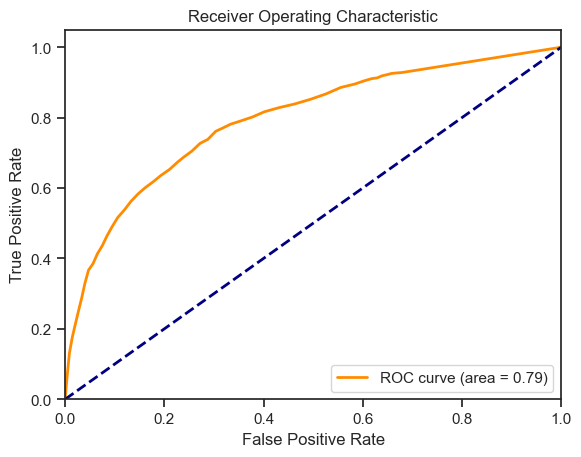

In [21]:
models_accuracy = pd.DataFrame(columns=['KNN', 'RForest', 'SVM', 'Neural Network' ])
knn = KNeighborsClassifier(n_neighbors=50).fit(X_train, y_train)
y_knn_n = knn.predict(X_test)
y_prob_knn = knn.predict_proba(X_test)[:, 1]

accuracy_knn = (accuracy_score(y_test, y_knn_n))*100
roc_knn= roc_auc_score(y_test, y_prob_knn)

plot_roc(y_test, y_prob_knn)



#### 6.2 -  Random Florest Classifier

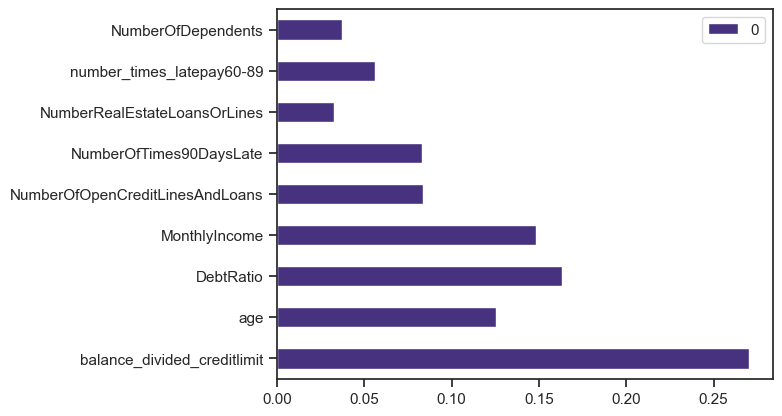

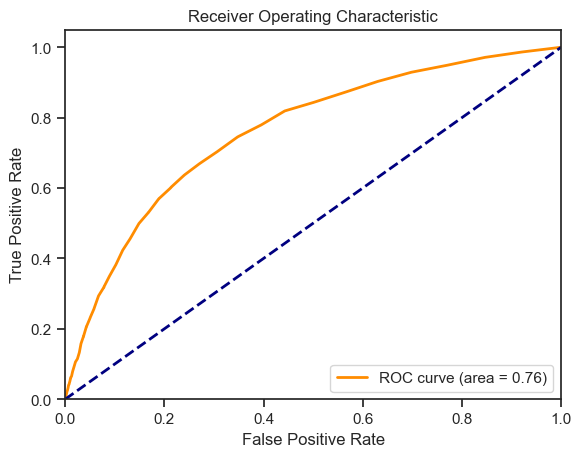

[[21919    48]
 [21740   227]]


In [22]:
# Model
forest = RandomForestClassifier(random_state=0)
forest.fit(X_train, y_train)

#Predicts
y_RFC= forest.predict(X_test)
y_pred_prob = forest.predict_proba(X_test)[:, 1]

#Metrics
accuracy_RFC= (accuracy_score(y_test, y_RFC))*100
roc_rfc=roc_auc_score(y_test, y_pred_prob)

#plots

importance = forest.feature_importances_
global_importances = pd.DataFrame(importance, index=X_train.columns)


global_importances.plot.barh()
plot_roc(y_test, y_pred_prob)

print(confusion_matrix(y_test, y_RFC))

plt.show()

#### 6.3 - SVM

[[38.84463058 11.15536942]
 [14.73346383 35.26653617]]


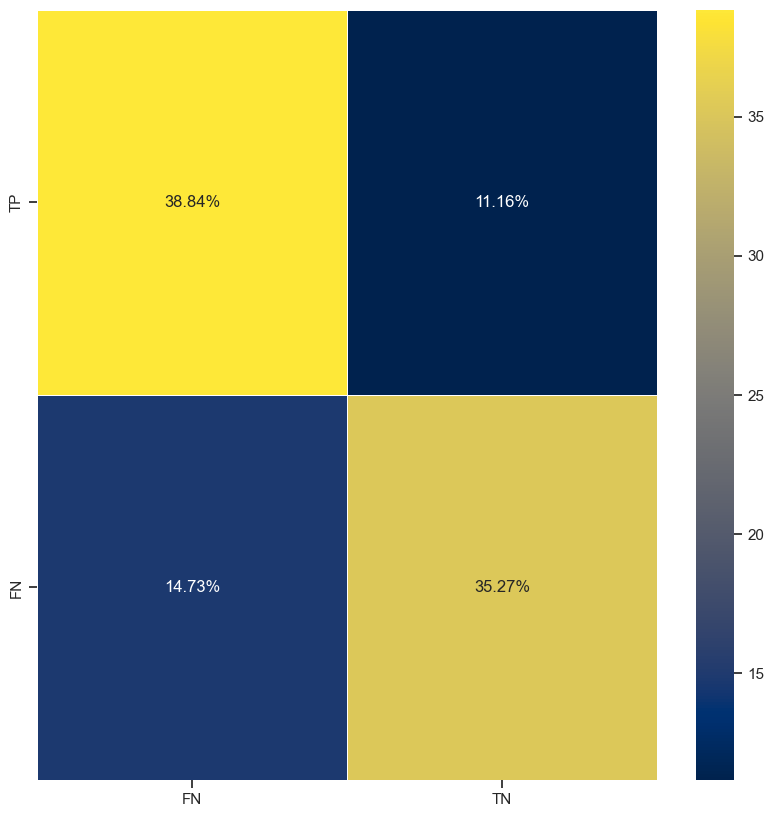

In [23]:

svm_model = LinearSVC(random_state=0)  
svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)


plot_confussion(y_test, y_pred )
cm_rf= classification_report(y_test, y_pred)
accuracy_SVM= (accuracy_score(y_pred, y_test))*100

##### Using K-fold Cross validation on SVM


In [29]:
k=5
kf= KFold(k, shuffle=True)
result_svm_kfold= cross_val_score(svm_model, X_train, y_train, cv= kf)
print(result_svm_kfold*100)
result_svm_kfold.mean()

[73.99022894 74.02715446 74.29131398 73.95330341 73.62665455]


0.7397773106856785

### Description
- Support Vector Machines (SVM)

#### 6.4 -  Neural networks

In [24]:
model =tf.keras.Sequential(
[tf.keras.layers.Input(shape=(9,)),
 tf.keras.layers.Dense(units=50, activation='relu', ),
 tf.keras.layers.Dense(units=100, activation='relu', ),
 tf.keras.layers.Dropout(0.2),
 tf.keras.layers.Dense(units=50, activation='relu', kernel_regularizer='l1' ),
 tf.keras.layers.Dense(units=1, activation='sigmoid', )
]
)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='binary_crossentropy',  metrics=[tf.keras.metrics.BinaryAccuracy()])
model.fit(X_train, y_train, batch_size=32, epochs=5)

Epoch 1/5
5509/5509 ━━━━━━━━━━━━━━━━━━━━ 5s 551us/step - binary_accuracy: 0.7410 - loss: 0.6728
Epoch 2/5
5509/5509 ━━━━━━━━━━━━━━━━━━━━ 3s 576us/step - binary_accuracy: 0.7464 - loss: 0.5926
Epoch 3/5
5509/5509 ━━━━━━━━━━━━━━━━━━━━ 3s 535us/step - binary_accuracy: 0.7479 - loss: 0.5888
Epoch 4/5
5509/5509 ━━━━━━━━━━━━━━━━━━━━ 3s 537us/step - binary_accuracy: 0.7497 - loss: 0.5862
Epoch 5/5
5509/5509 ━━━━━━━━━━━━━━━━━━━━ 3s 538us/step - binary_accuracy: 0.7486 - loss: 0.5844


In [56]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 50)             │           500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │         5,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,105 (125.41 KB)

 Trainable params: 10,701 (41.80 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 21,404 (83.61 KB)

In [25]:
y_nn=model.predict(X_test)
y_pred_nn = (y_nn >= 0.6).astype(int)
acc_NN= (accuracy_score(y_pred_nn, y_test ))*100
print(f"Model Accuracy: {acc_NN}")

1373/1373 ━━━━━━━━━━━━━━━━━━━━ 1s 402us/step
Model Accuracy: 73.86534346975007


In [60]:
report_knn= classification_report(y_test, y_knn_n, output_dict=True)
report_rfc= classification_report(y_test, y_RFC, output_dict=True)
report_svm= classification_report(y_test, y_pred, output_dict=True)
report_nn= classification_report(y_test, y_pred, output_dict=True)
print('----------  KNN  ----------\n')
print(pd.DataFrame(report_knn).T)
print('----------  Random Florest Classifier  ----------\n')
print(pd.DataFrame(report_rfc).T)
print('----------  Support Vector Machines (SVM)  ----------\n')
print(pd.DataFrame(report_svm).T)
print('----------  Neural Network  ----------')
print(pd.DataFrame(report_nn).T)

----------  KNN  ----------

              precision    recall  f1-score       support
0              0.702579  0.743673  0.722542  22089.000000
1              0.727749  0.685183  0.705825  22089.000000
accuracy       0.714428  0.714428  0.714428      0.714428
macro avg      0.715164  0.714428  0.714184  44178.000000
weighted avg   0.715164  0.714428  0.714184  44178.000000
----------  Random Florest Classifier  ----------

              precision    recall  f1-score       support
0              0.502350  0.996876  0.668052  22089.000000
1              0.799419  0.012450  0.024517  22089.000000
accuracy       0.504663  0.504663  0.504663      0.504663
macro avg      0.650884  0.504663  0.346285  44178.000000
weighted avg   0.650884  0.504663  0.346285  44178.000000
----------  Support Vector Machines (SVM)  ----------

              precision    recall  f1-score       support
0              0.723257  0.764906  0.743498  22089.000000
1              0.750540  0.707320  0.728290  22089.00

-------------------------------------- Classification Confussion Matrix in % --------------------------------------


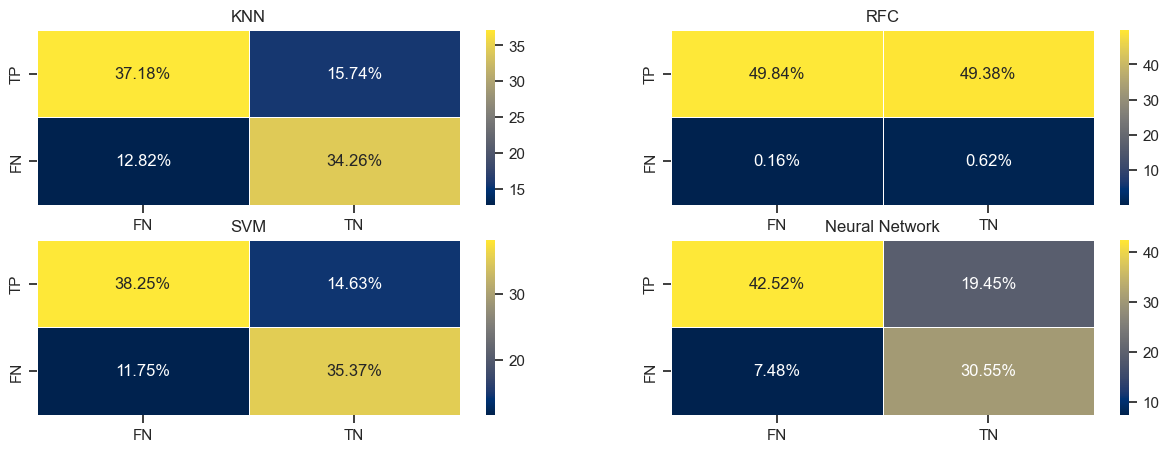

In [85]:
fig, axs =plt.subplots(2, 2, figsize=(15, 5))
plot_confussion_subplots(y_knn_n, y_test, ax=axs[0,0])
axs[0,0].set_title('KNN')

plot_confussion_subplots(y_RFC, y_test, ax=axs[0,1])
axs[0,1].set_title('RFC')
plot_confussion_subplots(y_pred, y_test, ax=axs[1,0])
axs[1,0].set_title('SVM')
plot_confussion_subplots(y_pred_nn, y_test, ax=axs[1,1])
axs[1,1].set_title('Neural Network')

print('-'*38, 'Classification Confussion Matrix in %' ,'-'*38)
plt.show()

In [26]:
models_accuracy.loc[0]= {'KNN':f'{accuracy_knn:.2f}%', 'RForest': f'{accuracy_RFC:.2f}%', 'SVM': f'{accuracy_SVM:.2f}%', 'Neural Network': f'{acc_NN:.2f}%'}
models_accuracy

,KNN,RForest,SVM,Neural Network
0,72.47%,50.41%,74.11%,73.87%


### Save the model

In [94]:
import pickle
path_model= os.path.join('..', 'model', 'model_svm.pkl')
# save
with open(path_model,'wb') as f:
    pickle.dump(svm_model, f)


### Load the model

In [127]:
with open(path_model, 'rb') as f:
    clf2 = pickle.load(f)

clf2.predict(X_train[176024:])

array([0, 1, 1, 1, 1, 1], dtype=int64)

# Final Considerations

- Although we have a relatively simple data cleaning and modeling, we've got incredible results!
- The worst model performed over the training and test examples was the Random Florest Classifier (RFC) with almost 50% of accuracy. A god point of view is that RFC got a **0.78 score** of AUC but is awful with accuracy and has an f1-score (in training examples where y = True) of **0.024** !!!

- For note: by just changing the normalization for Standard Scaler I've got a big I received a huge increase, especially in accuracy (not documented it above)